# Our Lovely Notebook on Toy Models 

## Import Libraries

In [5]:
using ControlSystems 

using Plots

## Section 1: Single Mass-Damper-Spring  
Goal: set-up state space representation

### Time-Domain Representation
Denote $x(t)$ position and $\dot{x}(t)$ speed at time $t$. Then equation of motion becomes  
$$ m \, \ddot{x}(t) + d \, \dot{x}(t) + k \, x(t) = F(t)$$
supplied with initial conditions. 

### State Space Representation 
State-space representation
$ X = \begin{pmatrix} x \\ \dot{x} \end{pmatrix}$ 
$$ \dot{X} = A X + B u \\ y = C X + D u $$ 
where $A = \begin{pmatrix} 0 & 1 \\ -k/m & -d/m \end{pmatrix}$, 
$B = \begin{pmatrix} 0 \\ F_0 \end{pmatrix}$, 
$C = \begin{pmatrix} 0 & 1 \end{pmatrix}$ and $D=0$.    

In [28]:
m = 1;     # point-mass
k = 2;     # spring constant 
d = 1e-2; # damping constant 
F0 = 1;    # amplitude of external forcing 
A = [0 1; -k/m -d/m];
B = [0 ; F0]; 
C = [1 0]; # select position data 
D = [0];   # not used 
pointMassSys = ss(A,B,C,D)

StateSpace{Continuous, Float64}
A = 
  0.0   1.0
 -2.0  -0.01
B = 
 0.0
 1.0
C = 
 1.0  0.0
D = 
 0.0

Continuous-time state-space model

### Convert to Frequency Domain 

In [34]:
mytf = tf(pointMassSys)

TransferFunction{Continuous, ControlSystemsBase.SisoRational{Float64}}
    1.734723475976807e-18s + 1.0
------------------------------------
1.0s^2 + 0.010000000000000002s + 2.0

Continuous-time transfer function model

In [31]:
?bodeplot

search: bodeplot bodeplot!



```
fig = bodeplot(sys, args...)
bodeplot(LTISystem[sys1, sys2...], args...; plotphase=true, kwargs...)
```

Create a Bode plot of the `LTISystem`(s). A frequency vector `w` can be optionally provided. To change the Magnitude scale see `setPlotScale(str)`

If `hz=true`, the plot x-axis will be displayed in Hertz, the input frequency vector is still treated as rad/s.

`kwargs` is sent as argument to RecipesBase.plot.


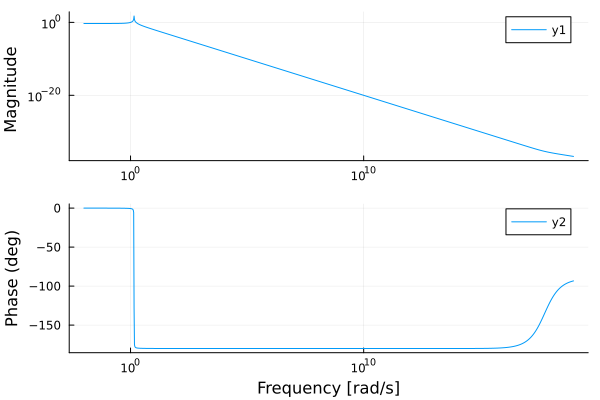

In [37]:
bodeplot(mytf)
#bodeplot(pointMassSys)
#bodeplot(mytf)

## Section 2: Double Masses-Dampers-Springs
Goal: explore how to deal with external variables with hidden variables. 

### Time-Domain Representation
Denote $x(t)$ position and $\dot{x}(t)$ speed of point mass $m_1$ at time $t$. $x(t)$ variable to be observed. Denote $y(t)$ position and $\dot{y}(t)$ speed of point mass $m_2$ at time $t$. $y(t)$ hidden variable. No forcing on the hidden variable. 

Mass matrix $M = \begin{pmatrix} m_1 & 0 \\ 0 & m_2 \end{pmatrix}$
Damping matrix $D = \begin{pmatrix} d_{11} & 0 \\ 0 & d_{22} \end{pmatrix}$
Stiffness matrix $K = \begin{pmatrix} k_{11} & 0 \\ 0 & k_{22} \end{pmatrix}$

Then equations of motion become  
$$ M \, \begin{pmatrix} \ddot{x}(t) \\ \ddot{y}(t) \end{pmatrix}
   + D \, \begin{pmatrix} \dot{x}(t) \\ \dot{y}(t) \end{pmatrix}
   + K \, \begin{pmatrix} x(t) \\ y(t) \end{pmatrix}
   = \begin{pmatrix} F(t) \\ 0 \end{pmatrix}$$
supplied with initial conditions. 



In [48]:
m1 = 1; m2 = 2;    # value of point-masses 
M = [m1 0; 0 m2];  # mass matrix 
k11 = 2; k22 = 3; k12 = 1; k21 = k12;   # stiffness coefficients 
K = [k11+k12 -k12; -k21 k22+k21];       # stiffness matrix 
d11 = 2; d22 = 3; d12 = 1; d21 = k12;   # damping coefficients;
D = 1e-6*[d11+d12 -d12; -d21 d22+d21];       # stiffness matrix
F0 = 1;  
A = [0 0 1 0; 0 0 0 1; M\D M\K];
B = [0 ; 0; F0; 0]; 
C = [1 0 0 0]; 
DD = [0]; # not used 
twoMassSys = ss(A,B,C,DD)

StateSpace{Continuous, Float64}
A = 
  0.0      0.0      1.0   0.0
  0.0      0.0      0.0   1.0
  3.0e-6  -1.0e-6   3.0  -1.0
 -5.0e-7   2.0e-6  -0.5   2.0
B = 
 0.0
 0.0
 1.0
 0.0
C = 
 1.0  0.0  0.0  0.0
D = 
 0.0

Continuous-time state-space model

In [50]:
?bodeplot

search: bodeplot bodeplot!



```
fig = bodeplot(sys, args...)
bodeplot(LTISystem[sys1, sys2...], args...; plotphase=true, kwargs...)
```

Create a Bode plot of the `LTISystem`(s). A frequency vector `w` can be optionally provided. To change the Magnitude scale see `setPlotScale(str)`

If `hz=true`, the plot x-axis will be displayed in Hertz, the input frequency vector is still treated as rad/s.

`kwargs` is sent as argument to RecipesBase.plot.


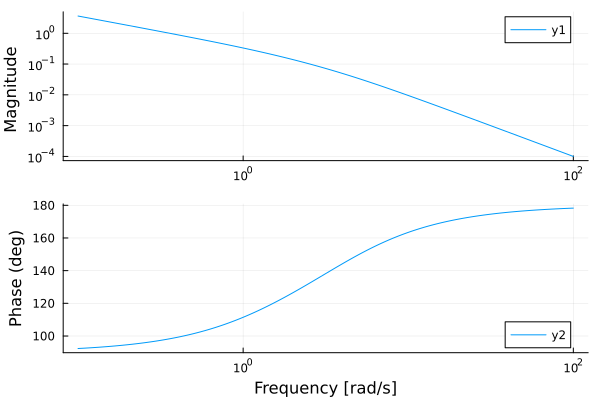

In [61]:
freqrange = Vector[1e-3:10:1e4]
bodeplot(twoMassSys;kwargs=freqrange)